**Задание**
Реализовать суммаризацию текста

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [16]:
# !pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy
# !pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
# !python -m spacy download ru_core_news_md

In [35]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r",  encoding='utf-8') as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [11]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [12]:
train_records[1].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [13]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()
    
    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [14]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


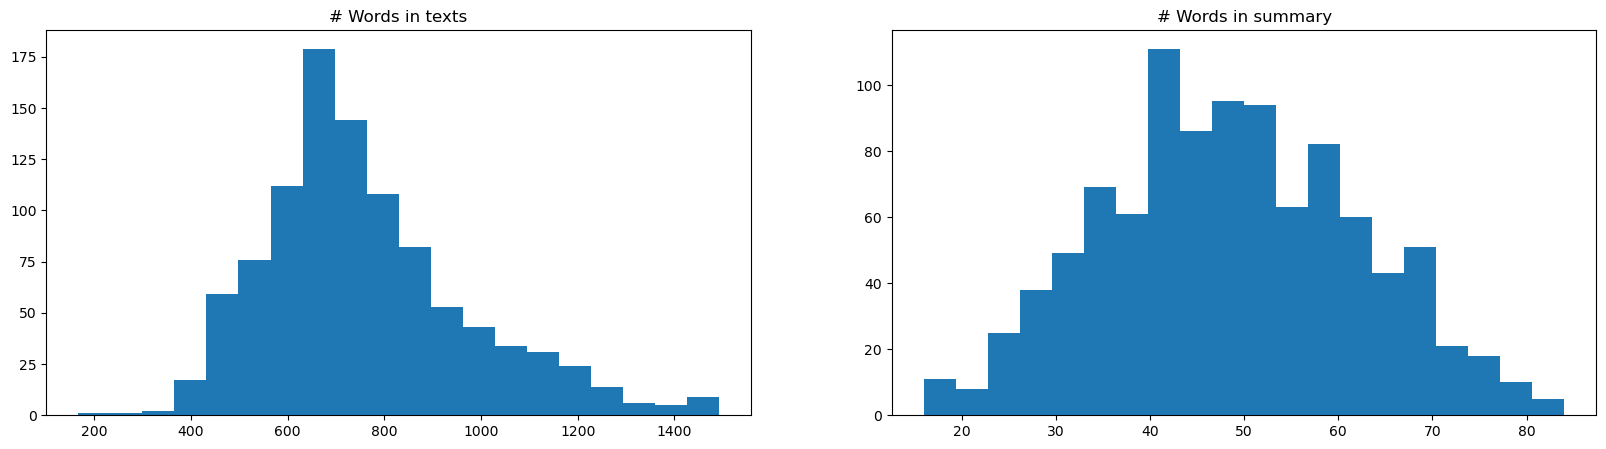

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

In [17]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [18]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'f': 0.23804097238957525, 'p': 0.22208274285774904, 'r': 0.37762764047433917}, 'rouge-2': {'f': 0.10027796832321115, 'p': 0.09647636782929753, 'r': 0.15833772153385062}, 'rouge-l': {'f': 0.1835646488408507, 'p': 0.2022959168891477, 'r': 0.34937017731940756}}


In [24]:
test_records[0]['text']

'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из выбранн

In [23]:
test_records[0]['summary']

'В NASA назвали четыре миссии в дальний космос, которые в этом десятилетии могут быть запущены американцами. Среди них — две миссии по изучению Венеры, полет к спутнику Юпитера и экспедиция к Тритону, спутнику Нептуна.'

In [43]:
# Делаем предобработку

import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие']
['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'американский', 'научный', 'команда', 'котором', 'участвовать', 'десять', 'миссия', 'они', 'были', 'отобрать', 'критерий', 'потенциальный', 'польза', 'наука', 'технический', 'осуществимость', 'проект', 'рамка', 'программа', 'discovery', 'nasa', 'заниматься', 'планирование', 'миссия', 'которые', 'призваны', 'дать', 'ответ', 'фундаментальный', 'вопрос', 'происхождение', 'тело', 'солнечный', 'система', 'возможный', 'наличие

In [117]:
from collections import Counter

class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            #print(sentence)
            # Значимость предложений - максимум из значимостей промежутков.
            
            chunks = self._get_chunk_ratings(sentence, all_significant_tokens)
            if len(chunks) == 0:
                sentence_rating = 0
            else: 
                sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))
            #print('ok')

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens
            
            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False
        
        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk): 
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [118]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 

In [119]:
lev_records = read_gazeta_records("lev.txt")

In [120]:
# Пример работы обоих методов.
lev_text = lev_records[0]["text"]

In [122]:
#luhn = LuhnSummarizer(verbose=False)
summary = luhn(lev_text, 3)
print()
print("Текст: {}".format(lev_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(lev_records[0]["summary"]))


Текст: В середине разговора про политические действия Анна Павловна разгорячилась. Ах, не говорите мне про Австрию! Я ничего не понимаю, может быть, но Австрия никогда не хотела и не хочет войны. Она предает нас. Россия одна должна быть спасительницей Европы. Наш благодетель знает свое высокое призвание и будет верен ему. Вот одно, во что я верю. Нашему доброму и чудному государю предстоит величайшая роль в мире, и он так добродетелен и хорош, что Бог не оставит его, и он исполнит свое призвание задавить гидру революции, которая теперь еще ужаснее в лице этого убийцы и злодея. Мы одни должны искупить кровь праведника. На кого нам надеяться, я вас спрашиваю. Англия с своим коммерческим духом не поймет и не может понять всю высоту души императора Александра. Она отказалась очистить Мальту. Она хочет видеть, ищет заднюю мысль наших действий. Что они сказали Новосильцеву? Ничего. Они не поняли, они не могли понять самоотвержения нашего императора, который ничего не хочет для себя и все хо

In [125]:
import pandas as pd

In [126]:
df_train = pd.DataFrame(train_records)

In [127]:
df_test = pd.DataFrame(test_records)
df_test[:3]

,url,text,title,summary,date
0,https://www.gazeta.ru/science/2020/02/14_a_129...,Американское аэрокосмическое агентство NASA ог...,"Венера, Ио или Тритон: куда полетит NASA","В NASA назвали четыре миссии в дальний космос,...",2020-02-14 16:39:11
1,https://www.gazeta.ru/social/2020/02/28/129806...,Около 11 тысяч зрителей увидели все самое лучш...,«Люди в Бурятии очень талантливые»,25 и 26 февраля в Кремлевском дворце съездов п...,2020-02-28 10:44:13
2,https://www.gazeta.ru/politics/2019/11/07_a_12...,7 ноября в Белоруссии прошли выборы членов сов...,Вспомнить СССР: как Лукашенко провел выборы,В Белоруссии в день годовщины Октябрьской рево...,2019-11-07 19:55:08


In [128]:
df_train['summary_clean'] = df_train['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_test['summary_clean'] = df_test['summary'].apply(lambda v: 'BOS ' + v + ' EOS')
df_train['summary_clean'][:5]

0    BOS В 2011 году из России уйдет $80 млрд, счит...
1    BOS Юлия Соловьева, экс-директор холдинга «Про...
2    BOS Суд арестовал на два месяца четверых экс-ч...
3    BOS Мнения предпринимателей по поводу вступлен...
4    BOS На Первом канале завершился третий сезон ш...
Name: summary_clean, dtype: object

In [129]:
MAX_TRAIN_SAMPLE = 1000
MAX_TEST_SAMPLE = 200

df_train = df_train[:MAX_TRAIN_SAMPLE]
df_test = df_test[:MAX_TEST_SAMPLE]

In [130]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [131]:
max_len_text = 700
max_len_sum = 70

In [132]:
#tok_text = Tokenizer(oov_token='UNK')
tok_text = Tokenizer()
tok_text.fit_on_texts(df_train['text'])
x_train_tok = tok_text.texts_to_sequences(df_train['text'])
x_test_tok = tok_text.texts_to_sequences(df_test['text'])

In [133]:
text_vocab_size=len(tok_text.word_index)+1

padded_x_train = pad_sequences(x_train_tok, maxlen=max_len_text, padding='post', truncating='post')
padded_x_test = pad_sequences(x_test_tok, maxlen=max_len_text, padding='post', truncating='post')

In [134]:
#tok_sum = Tokenizer(oov_token='UNK')
tok_sum = Tokenizer()
tok_sum.fit_on_texts(df_train['summary_clean'])
x_train_sum = tok_sum.texts_to_sequences(df_train['summary_clean'])
x_test_sum = tok_sum.texts_to_sequences(df_test['summary_clean'])

sum_vocab_size=len(tok_sum.word_index)+1

padded_x_train_sum = pad_sequences(x_train_sum, maxlen=max_len_sum, padding='post', truncating='post')
padded_x_test_sum = pad_sequences(x_test_sum, maxlen=max_len_sum, padding='post', truncating='post')

In [135]:
padded_x_train_sum.shape

(1000, 70)

In [136]:
reverse_text_index=tok_text.index_word
reverse_sum_index=tok_sum.index_word
sum_wordindex=tok_sum.word_index

In [137]:
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, TimeDistributed, Softmax, Dense, RepeatVector, Concatenate, Dense
from tensorflow.keras.models import Model

In [138]:
latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_len_text,))

#embedding layer
enc_emb =  Embedding(text_vocab_size, embedding_dim, trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,return_state=True,dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) #encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(sum_vocab_size, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(sum_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 700)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 700, 200)     17664000    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 700, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [139]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

In [140]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [141]:
history = model.fit([padded_x_train, padded_x_train_sum[:,:-1]], padded_x_train_sum.reshape(padded_x_train_sum.shape[0],padded_x_train_sum.shape[1], 1)[:,1:],
                    epochs=3,
                    validation_data=([padded_x_test, padded_x_test_sum[:,:-1]], padded_x_test_sum.reshape(padded_x_test_sum.shape[0], padded_x_test_sum.shape[1], 1)[:,1:]),
                    batch_size=16)

Epoch 1/3
63/63 [==============================] - 1726s 27s/step - loss: 6.6732 - accuracy: 0.3770 - val_loss: 4.2885 - val_accuracy: 0.4946
Epoch 2/3
63/63 [==============================] - 1768s 28s/step - loss: 5.3491 - accuracy: 0.3963 - val_loss: 3.8978 - val_accuracy: 0.5250
Epoch 3/3
63/63 [==============================] - 1787s 28s/step - loss: 5.1114 - accuracy: 0.4100 - val_loss: 3.8619 - val_accuracy: 0.5307


In [142]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [143]:
import numpy as np

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = sum_wordindex['bos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_sum_index[sampled_token_index]
        
        if(sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (max_len_sum - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [144]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=sum_wordindex['bos']) and i!=sum_wordindex['eos']):
            newString=newString+reverse_sum_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_text_index[i]+' '
    return newString


In [145]:
for i in range(0, 3):
    #print("Review:",seq2text(padded_x_test[i]))
    print("Original summary:",seq2summary(padded_x_test_sum[i]))

    print("Predicted summary:",decode_sequence(padded_x_test[i].reshape(1, max_len_text)))
    print("\n")

Original summary: в nasa назвали четыре миссии в космос которые в этом могут быть американцами среди них — две миссии по полет к и к 
1/1 [==============================] - 0s 28ms/step
Predicted summary:  в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в


Original summary: 25 и 26 февраля в праздновали — новый год центр российского и один из регионов страны где новый год официально дважды 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в


Original summary: в белоруссии в день революции выбрали членов палаты парламента сегодняшнее голосование — основной части процесса через десять дней в республике пройдут выборы в палату представителей которые станут для александра лукашенко ведь за ними будут следить на западе 
1/1 [==============================] - 0s 29ms/step
Predicted summary:  в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в в 

In [146]:
import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

In [149]:
from tqdm.notebook import tqdm
import razdel

def calc_oracle_score(records, nrows=10, lower=True):
    references = []
    predictions = []
    rouge = Rouge()
  
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        predicted_summary, _ = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge))
        predictions.append(predicted_summary)

    calc_scores(references, predictions)


calc_oracle_score(test_records)

0it [00:00, ?it/s]

Count: 10
Ref: работающие пенсионеры дождались индексации. это следует из уже одобренных в первом чтении поправок в конституцию. так что работающие пенсионеры смогут получить замороженную с 2016 года прибавку к пенсии. в россии их насчитывается более девяти миллионов. эксперты называют это восстановлением справедливости.
Hyp: госдума одобрила в первом чтении внесенные президентом рф владимиром путиным поправки в конституцию. индексация пенсий всем работающим пенсионерам, в том числе с инвалидностью, не производится с 2016 года.
BLEU:  0.4674568071233261
ROUGE:  {'rouge-1': {'f': 0.32893752698453543, 'p': 0.3371218760231365, 'r': 0.3415312679480252}, 'rouge-2': {'f': 0.17707827296439094, 'p': 0.18320770481334162, 'r': 0.18641473904295192}, 'rouge-l': {'f': 0.2959611065900263, 'p': 0.31890108770781034, 'r': 0.3261824668149578}}


In [150]:
calc_oracle_score(lev_records)

0it [00:00, ?it/s]

Count: 1
Ref: анна павловна сказала, что австрия предает россию. англия не понимает россию. пруссия объявила о непобедимости наполеона. александр спасет европу.
Hyp: в середине разговора про политические действия анна павловна разгорячилась.
BLEU:  0.15157257653900366
ROUGE:  {'rouge-1': {'f': 0.14814814370370383, 'p': 0.2222222222222222, 'r': 0.1111111111111111}, 'rouge-2': {'f': 0.07692307266272212, 'p': 0.125, 'r': 0.05555555555555555}, 'rouge-l': {'f': 0.12345679012353086, 'p': 0.2222222222222222, 'r': 0.1111111111111111}}
